**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Motivation**: To create a multiclass classification model using a custom convolutional neural network in tensorflow




**Data Summary**The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:





1.   Actinic keratosis
2.   Basal cell carcinoma
3.   Dermatofibroma
4.   Melanoma
5.   Nevus
6.   Pigmented benign keratosis
7.   Seborrheic keratosis
8.   Squamous cell carcinoma
9.   Vascular lesion



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [3]:
from tensorflow.keras.layers import BatchNormalization

## Loading the Data

In [4]:
root_path = '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [5]:
image_len_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_len_train)
image_len_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_len_test)

2239
118


## Load Using Keras Preprocessing

In [6]:
#Define some parameters
batch_size = 32
img_height = 180
img_width = 180


In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [9]:
classes = train_ds.class_names
print(classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualising the Images of each class

105


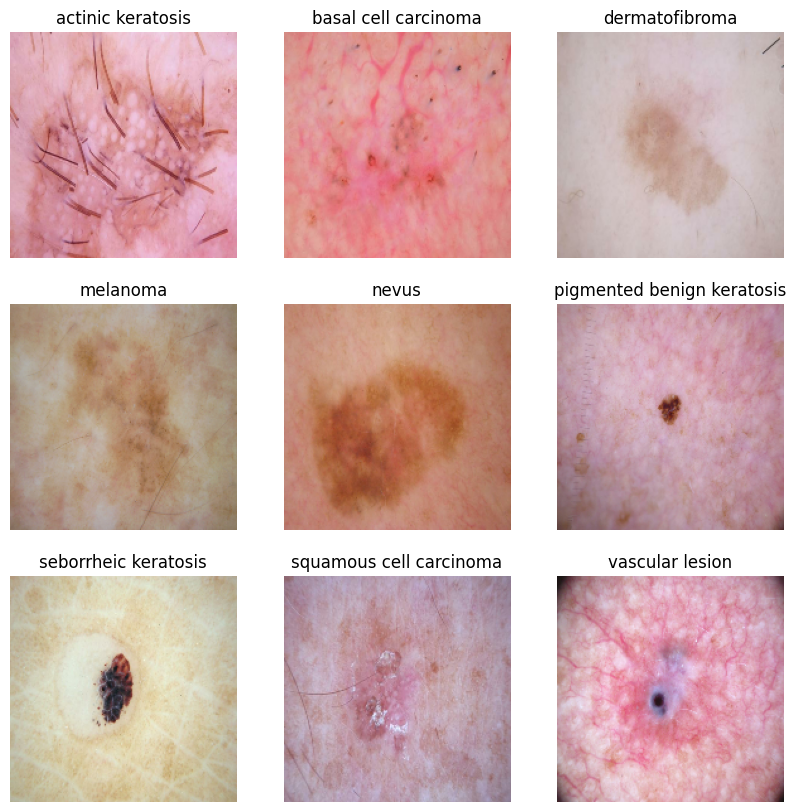

In [10]:
import matplotlib.pyplot as plt
import random
num_batch_trainds = train_ds.cardinality().numpy()
random_batch = random.randint(1,num_batch_trainds)
print(random_batch)

plt.figure(figsize=(10, 10))
# Getting the image related to a specific class and plotting them
for i in range(len(classes)):
   filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
   for image, label in filtered_ds.take(random_batch):
       ax = plt.subplot(3, 3, i+1)
       plt.imshow(image[0].numpy().astype('uint8'))
       plt.title(classes[label.numpy()[0]])
       plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model and train the model

In [12]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes)
])

### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 54s 90ms/step - loss: 1.9284 - accuracy: 0.2541 - val_loss: 1.9795 - val_accuracy: 0.2174
Epoch 2/20
169/169 [==============================] - 4s 24ms/step - loss: 1.6150 - accuracy: 0.3837 - val_loss: 1.7516 - val_accuracy: 0.2174
Epoch 3/20
169/169 [==============================] - 4s 23ms/step - loss: 1.5269 - accuracy: 0.4169 - val_loss: 2.0713 - val_accuracy: 0.1739
Epoch 4/20
169/169 [==============================] - 4s 22ms/step - loss: 1.4173 - accuracy: 0.4538 - val_loss: 2.1548 - val_accuracy: 0.2609
Epoch 5/20
169/169 [==============================] - 4s 22ms/step - loss: 1.3194 - accuracy: 0.5035 - val_loss: 1.9889 - val_accuracy: 0.3043
Epoch 6/20
169/169 [==============================] - 4s 23ms/step - loss: 1.2252 - accuracy: 0.5341 - val_loss: 2.3501 - val_accuracy: 0.2609
Epoch 7/20
169/169 [==============================] - 4s 23ms/step - loss: 1.1093 - accuracy: 0.5825 - val_loss: 3.3343 - val_accuracy: 0.347

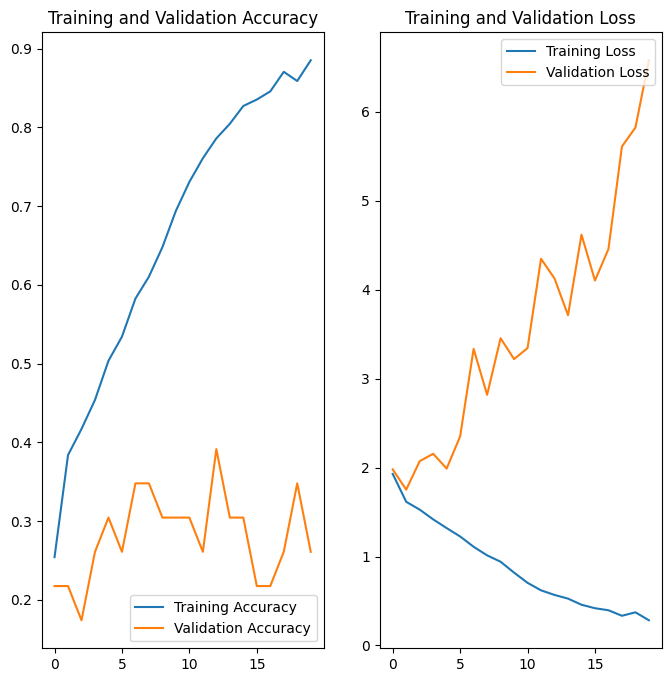

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 30% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable — a sign of overfitting.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomFlip("vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.5),
    layers.experimental.preprocessing.RandomContrast(0.5),
    #layers.experimental.preprocessing.RandomBrightness(0.3)
  ]
)

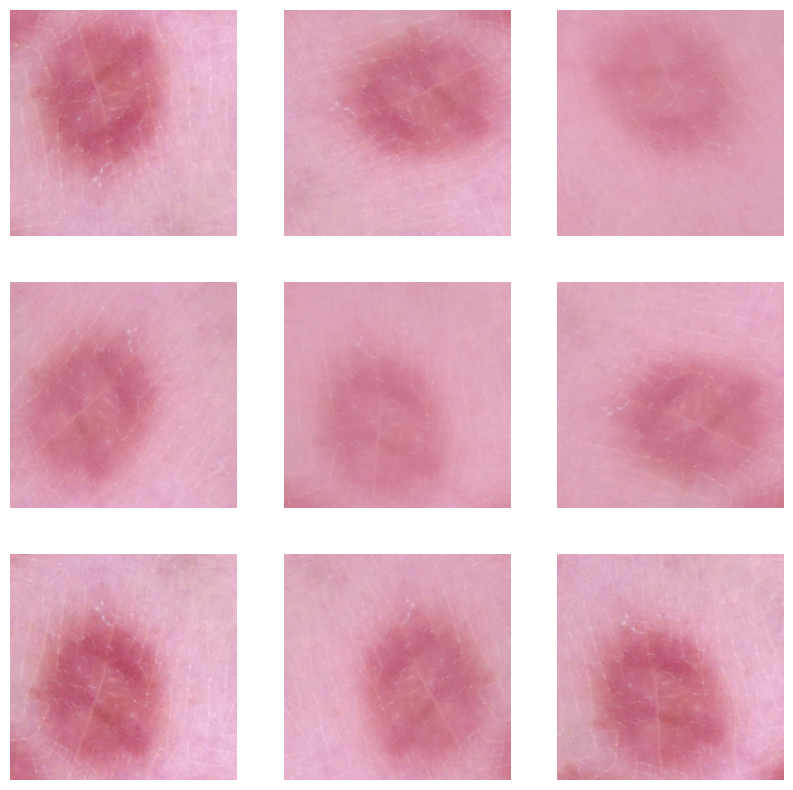

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Model 2 After Data augmentation

In [18]:

## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes)
])

## Compile the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 8s 27ms/step - loss: 1.9831 - accuracy: 0.2417 - val_loss: 2.0540 - val_accuracy: 0.3043
Epoch 2/20
169/169 [==============================] - 4s 25ms/step - loss: 1.6679 - accuracy: 0.3694 - val_loss: 2.2520 - val_accuracy: 0.2609
Epoch 3/20
169/169 [==============================] - 4s 26ms/step - loss: 1.6061 - accuracy: 0.3887 - val_loss: 2.1391 - val_accuracy: 0.3043
Epoch 4/20
169/169 [==============================] - 4s 26ms/step - loss: 1.5392 - accuracy: 0.4088 - val_loss: 2.2110 - val_accuracy: 0.3478
Epoch 5/20
169/169 [==============================] - 4s 25ms/step - loss: 1.4825 - accuracy: 0.4343 - val_loss: 2.5358 - val_accuracy: 0.1739
Epoch 6/20
169/169 [==============================] - 4s 25ms/step - loss: 1.4710 - accuracy: 0.4405 - val_loss: 1.9778 - val_accuracy: 0.3043
Epoch 7/20
169/169 [==============================] - 5s 27ms/step - loss: 1.4281 - accuracy: 0.4531 - val_loss: 1.9847 - val_accuracy: 0.2609

## Visualizing Results

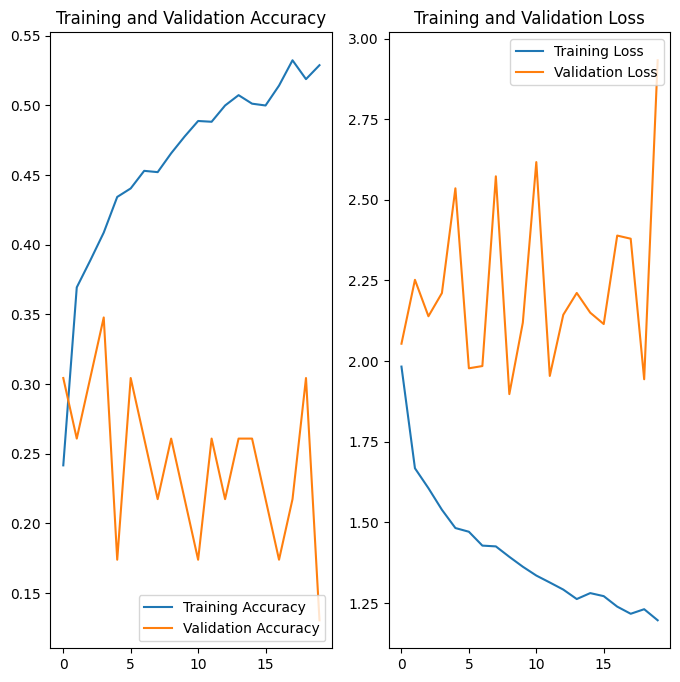

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### We can see that even after the slight data augmentation, there was very little affect on the gap between the training accuracy and the vaidation accuracy. Now we will be checking the class imbalance in the dataset

## Determining the Class imbalance

In [22]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [23]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
1,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
2,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
3,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
4,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma
2235,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma
2236,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma
2237,/content/drive/MyDrive/Skin cancer ISIC The In...,dermatofibroma


Class=0, n=114 (5.092%)
Class=8, n=139 (6.208%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=1, n=376 (16.793%)
Class=7, n=181 (8.084%)
Class=3, n=438 (19.562%)
Class=6, n=77 (3.439%)
Class=2, n=95 (4.243%)


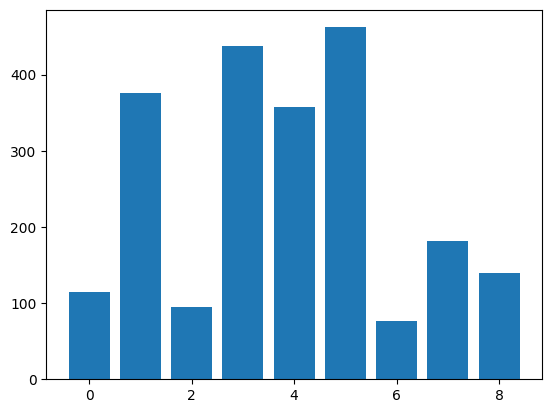

In [24]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [25]:
!pip install Augmentor

## Rectify the Class Imbalance

In [26]:
path_to_training_dataset='drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in classes:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F75F821BB50>: 100%|██████████| 500/500 [00:21<00:00, 23.18 Samples/s]


Initialised with 376 image(s) found.
Output directory set to drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F76471DBD90>: 100%|██████████| 500/500 [00:26<00:00, 18.70 Samples/s]


Initialised with 95 image(s) found.
Output directory set to drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F75F81E7D00>: 100%|██████████| 500/500 [00:20<00:00, 24.84 Samples/s]


Initialised with 438 image(s) found.
Output directory set to drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F75F805FE20>: 100%|██████████| 500/500 [01:32<00:00,  5.39 Samples/s]


Initialised with 357 image(s) found.
Output directory set to drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F75F80C2DA0>: 100%|██████████| 500/500 [01:26<00:00,  5.77 Samples/s]


Initialised with 462 image(s) found.
Output directory set to drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F75F8219D20>: 100%|██████████| 500/500 [00:19<00:00, 25.66 Samples/s]


Initialised with 77 image(s) found.
Output directory set to drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F76471D8160>: 100%|██████████| 500/500 [00:43<00:00, 11.52 Samples/s]


Initialised with 181 image(s) found.
Output directory set to drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F75F80B7F70>: 100%|██████████| 500/500 [00:20<00:00, 24.72 Samples/s]


Initialised with 139 image(s) found.
Output directory set to drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F75F8162C20>: 100%|██████████| 500/500 [00:19<00:00, 25.40 Samples/s]


In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


In [28]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_b9af8e53-9693-4dd3-87b2-150d13a06e08.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026650.jpg_7a783dee-34bc-4c76-ba32-9dfd5789a0bb.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_46f12e9f-2fcf-4bac-a5b6-0f13f253482a.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028941.jpg_432c7caf-b23b-4bf0-bc86-b0785419fa33.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_05f40fba-8894-4bd4

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [30]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-31-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [32]:
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### Create your model (including normalization)

In [36]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile your model

In [37]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####  Train your model

In [38]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 647s 526ms/step - loss: 2.0111 - accuracy: 0.4192 - val_loss: 2.8553 - val_accuracy: 0.1504
Epoch 2/30
281/281 [==============================] - 25s 89ms/step - loss: 1.0797 - accuracy: 0.5995 - val_loss: 1.2182 - val_accuracy: 0.5180
Epoch 3/30
281/281 [==============================] - 25s 89ms/step - loss: 0.7675 - accuracy: 0.7143 - val_loss: 2.0116 - val_accuracy: 0.3983
Epoch 4/30
281/281 [==============================] - 25s 89ms/step - loss: 0.5770 - accuracy: 0.7901 - val_loss: 1.7782 - val_accuracy: 0.5785
Epoch 5/30
281/281 [==============================] - 25s 90ms/step - loss: 0.4471 - accuracy: 0.8329 - val_loss: 2.0352 - val_accuracy: 0.4958
Epoch 6/30
281/281 [==============================] - 25s 89ms/step - loss: 0.3832 - accuracy: 0.8569 - val_loss: 0.9163 - val_accuracy: 0.7014
Epoch 7/30
281/281 [==============================] - 25s 89ms/step - loss: 0.3244 - accuracy: 0.8763 - val_loss: 4.5534 - val_accurac

#### Visualize the model results

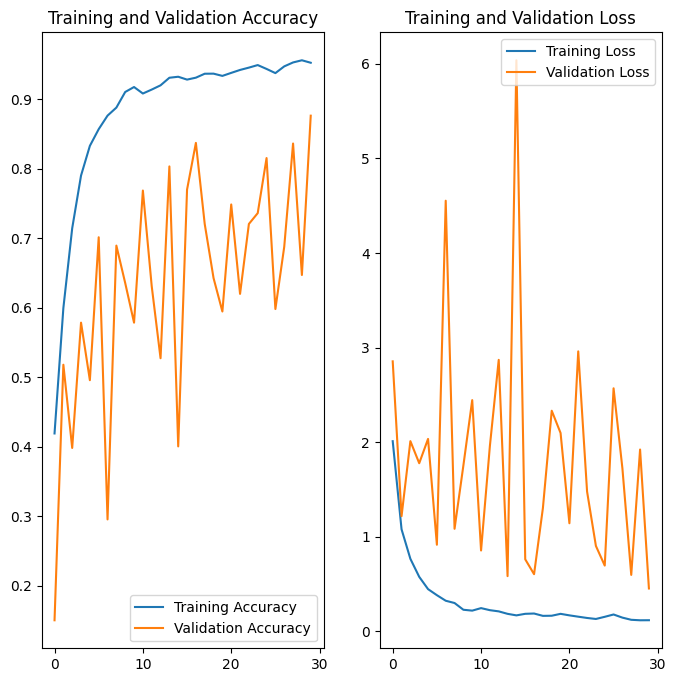

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Using the Data Augmentor, we were able to fix the class imbalance and also in turn fix the gap between the Training Accuracy and the Validation Accuracy. But let's see if we can achieve better results without using the Batch Normalization.


## Model 4 - Compiling Another Model without the Batch Normalization.

In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [41]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 21s 64ms/step - loss: 1.6441 - accuracy: 0.3634 - val_loss: 1.4399 - val_accuracy: 0.4762
Epoch 2/30
281/281 [==============================] - 17s 62ms/step - loss: 1.3148 - accuracy: 0.4992 - val_loss: 1.1539 - val_accuracy: 0.5594
Epoch 3/30
281/281 [==============================] - 17s 62ms/step - loss: 1.1025 - accuracy: 0.5830 - val_loss: 1.0003 - val_accuracy: 0.6235
Epoch 4/30
281/281 [==============================] - 17s 62ms/step - loss: 0.8769 - accuracy: 0.6698 - val_loss: 0.8934 - val_accuracy: 0.6684
Epoch 5/30
281/281 [==============================] - 18s 66ms/step - loss: 0.6715 - accuracy: 0.7521 - val_loss: 0.5959 - val_accuracy: 0.7775
Epoch 6/30
281/281 [==============================] - 20s 70ms/step - loss: 0.5534 - accuracy: 0.7913 - val_loss: 0.4956 - val_accuracy: 0.8291
Epoch 7/30
281/281 [==============================] - 19s 66ms/step - loss: 0.4395 - accuracy: 0.8407 - val_loss: 0.4801 - val_accuracy:

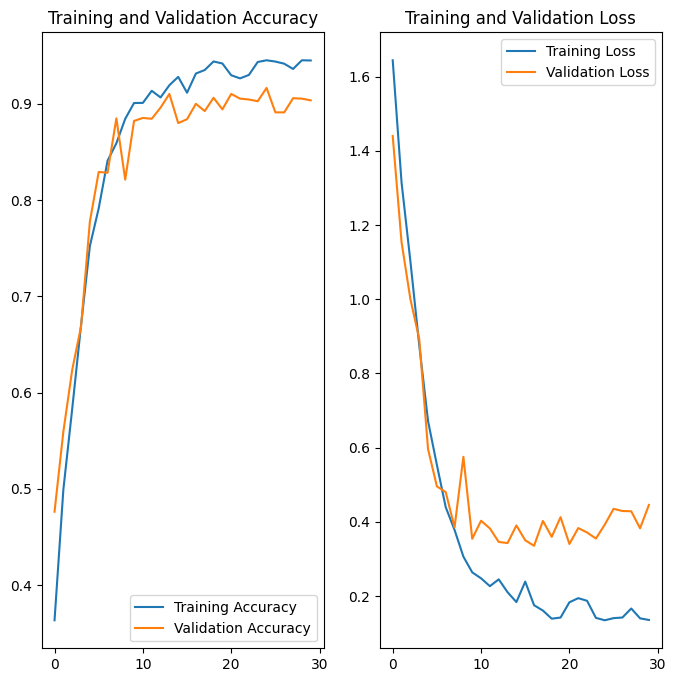

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####   Findings

1. The data needs to be autotuned and shuffled before creating the layers and sending the input.
2. It's important to augment the data if there are any Overfitting/Underfitting tendencies.
3. If there's a class imbalance that needs to be rectified. In this dataset there was a huge class imbalance which led to the gap in the training and the validation accuracy.
4. As we can see that we are able to achieve better results without the BatchNormalization as well.